In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from collections import OrderedDict

import copy

import matplotlib.pyplot as plt

from sklearn.datasets import make_moons

from tqdm.notebook import tqdm

In [2]:
# Basic Neural Network

class NeuralNetwork(nn.Module):
    def __init__(self, in_dim: int = 2, feature_dim: int = 10, out_dim: int = 2):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(in_dim, feature_dim)
        self.layer2 = nn.Linear(feature_dim, out_dim)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.layer1(x)
        x = self.act(x)
        x = self.layer2(x)
        return x


# Evaluation Method with Accuracy and CrossEntropyLoss as it's metrics

def evaluate(model, dataloader, criterion = nn.CrossEntropyLoss(), device: str = 'cuda'):
    model.to(device)
    model.eval()

    n_correct, n_samples, loss_total = 0, 0, 0

    for images, targets in dataloader:
        images, targets = images.to(device), targets.to(device)

        output = model(images)
        loss = criterion(output, targets)
        n_correct += torch.sum(output.softmax(-1).argmax(-1) == targets).item()
        n_samples += targets.shape[0]
        loss_total += loss.item() * targets.shape[0]
    
    acc1 = n_correct/n_samples
    loss_mean = loss_total/n_samples

    model.to('cpu')

    return {
        'acc1' : acc1,
        'loss' : loss_mean
    }

In [3]:
# Function to plot decision boundary of model

@torch.no_grad()
def plot_contour(model, X, y, ax=None):
    model.eval()
    model.cpu()
    origin = 'lower'
    if ax:
        plt.sca(ax)
    domain = 2.5
    xx, yy = torch.meshgrid(torch.linspace(-domain, domain, 51), torch.linspace(-domain, domain, 51), indexing='ij')
    zz = torch.stack((xx.flatten(), yy.flatten()), dim=1)

    logits = model(zz)
    probas = logits.softmax(-1)
    zz = probas[:, 1].view(xx.shape)

    plt.scatter(X[:, 0], X[:, 1], c=y, s=35, edgecolors='black')
    CS = plt.contourf(xx, yy, zz, alpha=.8, zorder=-1, levels=np.linspace(0, 1, 6), origin=origin)
    CS2 = plt.contour(CS, levels=[0.5], colors='black', origin=origin)
    cbar = plt.colorbar(CS)
    cbar.add_lines(CS2)

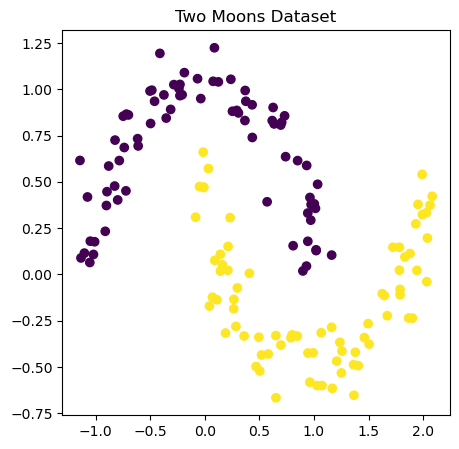

In [4]:
# 2D Sklearn Dataset

X, y = make_moons(n_samples=150, noise=0.1)
X, y = torch.tensor(X).float(), torch.tensor(y).long()
ds = TensorDataset(X, y)

plt.figure(figsize=(5, 5))
plt.title("Two Moons Dataset")
plt.scatter(X[:,0], X[:,1], c=y)
plt.show()

Scores:  {'acc1': 0.5, 'loss': 0.7027916844685872}


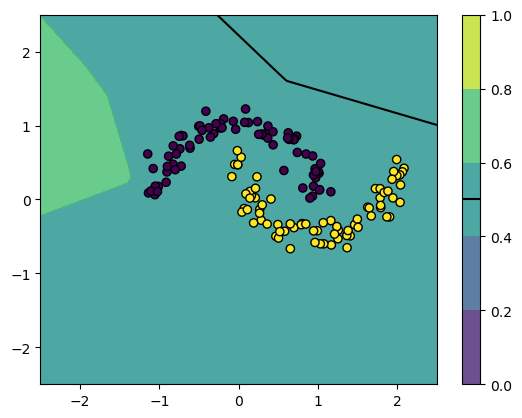

In [5]:
# How does a randomly initialized model perform?

model = NeuralNetwork()
dataloader = DataLoader(ds, batch_size=64)

scores = evaluate(model, dataloader)
print("Scores: ", scores)
plot_contour(model, X, y)

In [6]:
# Let's repeat that for a 1000 times and save the best performing model

best_model = None
best_score = -1

for i in tqdm(range(1000)):
    model = NeuralNetwork()
    dataloader = DataLoader(ds, batch_size=64)
    scores = evaluate(model, dataloader)
    if scores['acc1'] > best_score:
        best_score = scores['acc1']
        best_model = copy.deepcopy(model)
best_score

  0%|          | 0/1000 [00:00<?, ?it/s]

0.8866666666666667

In [7]:
def slight_variant(model, p_change: float = 0.2, d_change: float = 0.05):
    state_dict = model.state_dict()
    new_state_dict = OrderedDict()
    for key, layer in state_dict.items():
        mask = (torch.rand(layer.shape) < p_change).int()
        new_state_dict[key] = layer + (torch.rand(layer.shape) * d_change) * mask
    return new_state_dict

In [8]:
# Now we want to repeat evolutionary cycles and create offshores of previously well performing models.
# Out of 100 contesting models, the top ten models get to create 10 slightly variing models.

best_models = []
new_best_models = []

ultimate_model = None
ultimate_performance = None

for ev_cycle in tqdm(range(100)):
    if ev_cycle == 0:
        # Initialize first batch random
        new_best_models = [NeuralNetwork() for i in range(10)]
    best_models = copy.deepcopy(new_best_models)
    new_best_models = []
    best_performances = []
    for ranking, model in enumerate(best_models):
        for j in range(5*(10-ranking)):
            child_model = NeuralNetwork()
            child_model.load_state_dict(slight_variant(model, p_change=0.5, d_change=0.05))
            dataloader = DataLoader(ds, batch_size=64)
            child_performance = round(evaluate(child_model, dataloader)['acc1'], 4)

            if len(best_performances) < 10:
                inserted = False
                for i in range(len(best_performances)):
                    if child_performance > best_performances[i]:
                        best_performances.insert(i, child_performance)
                        new_best_models.insert(i, child_model)
                        inserted = True
                        break
                if not inserted:
                    best_performances.append(child_performance)
                    new_best_models.append(child_model)
            else:
                for i in range(10):
                    if child_performance > best_performances[i]:
                        best_performances.insert(i, child_performance)
                        best_performances.pop(-1)
                        new_best_models.insert(i, child_model)
                        new_best_models.pop(-1)
                        break
    if not ultimate_performance or best_performances[0] > ultimate_performance:
        ultimate_performance = best_performances[0]
        ultimate_model = copy.deepcopy(new_best_models[0])
    print(best_performances)
print("Ultimate Performance: ",ultimate_performance)

  0%|          | 0/100 [00:00<?, ?it/s]

[0.86, 0.86, 0.86, 0.8533, 0.8533, 0.8533, 0.8467, 0.8467, 0.8467, 0.8467]
[0.8933, 0.88, 0.88, 0.88, 0.8733, 0.8733, 0.8733, 0.8733, 0.8733, 0.8733]
[0.9, 0.9, 0.8933, 0.8933, 0.8933, 0.8867, 0.8867, 0.8867, 0.8867, 0.88]
[0.9067, 0.9067, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9]
[0.9133, 0.9133, 0.9067, 0.9067, 0.9067, 0.9067, 0.9067, 0.9, 0.9, 0.9]
[0.9267, 0.9267, 0.9267, 0.92, 0.92, 0.92, 0.92, 0.9133, 0.9133, 0.9133]
[0.94, 0.9333, 0.9333, 0.9267, 0.9267, 0.9267, 0.9267, 0.9267, 0.9267, 0.9267]
[0.94, 0.94, 0.94, 0.94, 0.94, 0.9333, 0.9333, 0.9333, 0.9267, 0.9267]
[0.9533, 0.9467, 0.9467, 0.9467, 0.9467, 0.9467, 0.9467, 0.9467, 0.94, 0.94]
[0.96, 0.96, 0.9533, 0.9533, 0.9533, 0.9533, 0.9533, 0.9533, 0.9467, 0.9467]
[0.9867, 0.9867, 0.9867, 0.9867, 0.9867, 0.98, 0.9733, 0.9733, 0.9733, 0.9733]
[0.9933, 0.9933, 0.9933, 0.9933, 0.9933, 0.9867, 0.9867, 0.9867, 0.9867, 0.9867]
[0.9933, 0.9933, 0.9933, 0.9933, 0.9933, 0.9933, 0.9933, 0.9933, 0.9867, 0.9867]
[0.9933, 0.9933, 0.9933, 0.986

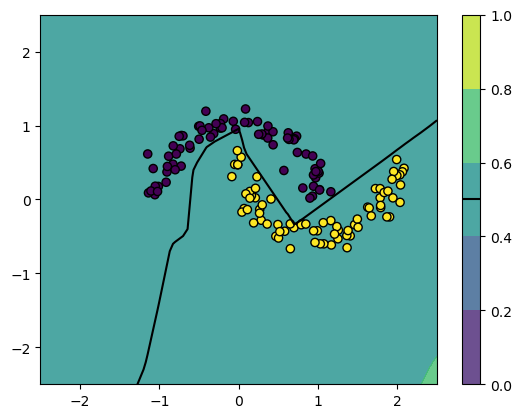

In [9]:
# Plot ultimate Models Decision Boundary

plot_contour(ultimate_model, X, y)